In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from config import settings
from src.data import datamodule as dm
from pathlib import Path
from src.model.transformation import (FromBuffer , 
                                      CutPSD, LogTransform , NormLayer , SqueezeLayer,
                                      UnsqueezeLayer)


import matplotlib.pyplot as plt
from torch import nn 
from src.data.utils import print_database_overview, load_all_from_db
from src.model.prepared_queries import view_melt_welch_only


In [ ]:
db_path = Path(settings.path.processed, 'processed.db')
assert db_path.exists(), f"Database not found at {db_path}"
print_database_overview(db_path)
meta_data = load_all_from_db(db_path, 'metadata')
frequency_axis = FromBuffer()(meta_data.loc[0,'frequency_axis'])

SQLite Database Overview
Table: processed_data - id, timestamp, turbine_name, Welch_X, Welch_Y, Welch_Z, RMS_X, RMS_Y, RMS_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z, Range_X, Range_Y, Range_Z, Mean_X, Mean_Y, Mean_Z
Table: sqlite_sequence - name, seq
Table: metadata - frequency_axis, sample_rate, window_size, processing_method
Table: scada - timestamp, mean_windspeed, min_windspeed, max_windspeed, std_windspeed, mean_yaw, min_yaw, max_yaw, std_yaw, mean_power, min_power, max_power, std_power, mean_pitch, min_pitch, max_pitch, std_pitch, mean_rpm, min_rpm, max_rpm, std_rpm, mean_winddirection, min_winddirection, max_winddirection, std_winddirection, mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, mean_NAC_ACC_FA, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, mean_NAC_ACC_SS, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, mean_ti, pred_Mtn_legacy, relative_wind_dir, pred_Mtn_dnn, Mean_muY, CoV, std_NAC_ACC

In [ ]:

columns = ["Welch"]
transform_func = [nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 2)),LogTransform())]
key_query  = f"""SELECT unique_id FROM melted_view 
WHERE timestamp BETWEEN '{settings.norther.training_start}' AND '{settings.norther.training_end}'
AND axis = 'Y'
"""


data_loader = dm.PSDDataModule(
    db_path=db_path,
    view_query=view_melt_welch_only, 
    view_table_name='melted_view',          # the view_table_name
    key_query=key_query,
    key_name='unique_id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=128,
    cached=True,
)


In [ ]:
import pytorch_lightning as pl
from src.model.backcone import AutoEncoderConv, AutoEncoder
from torch import optim
class TrainingAutoEncoderConv(pl.LightningModule):
    def __init__(self, lr: float):
        super().__init__()
        self.model = AutoEncoder()
        self.lr = lr
        self.loss = nn.L1Loss()
        self.save_hyperparameters(ignore=['model'])
        
    def forward(self, x):
        return self.model(x)
    
    def forward_embedding(self, x):
        return self.model.encoder(x)

    def _common_step(self, batch, batch_idx, stage):
        x = batch[0]
        x_hat = self.model(x)
        loss = self.loss(x, x_hat)
        self.log(f'{stage}_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'val')
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar

mlflow_logger = MLFlowLogger(experiment_name="CAE-allturbine",
                            save_dir=settings.path.mlflow[1:])

checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, filename='AE-{epoch:02d}-{val_loss:.2f}')
trainer = pl.Trainer(max_epochs=5, logger=mlflow_logger, callbacks=[checkpoint_callback, RichProgressBar()])
model_ae = TrainingAutoEncoderConv(lr=1e-3)

trainer.fit(model_ae, data_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Already set


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type        ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model │ AutoEncoder │ 89.8 K │ train │
│ 1 │ loss  │ L1Loss      │      0 │ train │
└───┴───────┴─────────────┴────────┴───────┘

Trainable params: 89.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 89.8 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

In [ ]:
best_model_path = Path(checkpoint_callback.best_model_path)
model_ae = TrainingAutoEncoderConv.load_from_checkpoint(best_model_path)


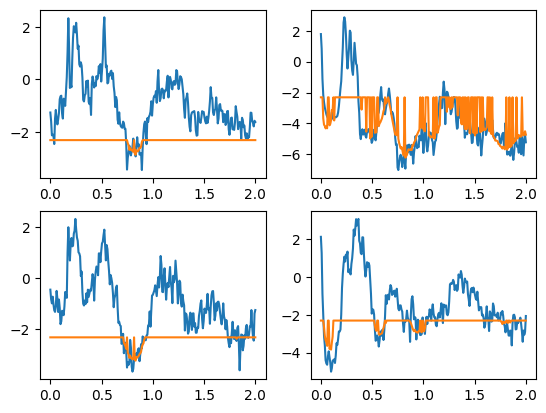

In [ ]:
data = next(iter(data_loader.train_dataloader()))[0]
data = data.to(model_ae.device)
data_rec = model_ae(data)
fig,ax  = plt.subplots(2,2)
for i,(psd_in, psd_out) in enumerate(zip(data[0:4], data_rec[0:4])):
    ax[i//2, i%2].plot(frequency_axis[0:263], psd_in.cpu().numpy())
    ax[i//2, i%2].plot(frequency_axis[0:263], psd_out.cpu().detach().numpy())
plt.show()


In [ ]:
data_loader.__del__()

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import create_merge_scada
columns = ["Welch","DEM"]
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = [nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 2)),LogTransform()),ToTensor()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM merged 
WHERE timestamp BETWEEN '{settings.norther.training_start}' AND '{settings.norther.training_end}'
AND Turbine_name =='NRTC01'
"""


data_loader_dem = dm.PSDDataModule(
    db_path=db_path,
    view_query=create_merge_scada, 
    view_table_name='merged',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=32,
    cached=True,
)


In [ ]:
import torch
from torch import nn, optim
import pytorch_lightning as pl
from src.model.backcone import SimpleMLP

class AutoEncoderRegressor(pl.LightningModule):
    def __init__(self, encoder: nn.Module, regressor: nn.Module, lr: float = 1e-3):
        super(AutoEncoderRegressor, self).__init__()
        self.encoder = encoder
        self.regressor = regressor
        self.lr = lr
        self.loss_fn = nn.MSELoss()  # Assuming DEM is a continuous variable


        
        # Freeze the encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.regressor.parameters():
            param.requires_grad = True
        self.model = nn.Sequential(encoder, regressor)
        self.save_hyperparameters(ignore=['encoder', 'regressor'])


    def forward(self, x):
        with torch.no_grad():  # Ensures no gradients are computed for the encoder
            encoded = self.encoder(x)
        pred = self.regressor(encoded)
        return pred
    

    def training_step(self, batch, batch_idx):
        x, y = batch  # x: Welch, y: DEM
        y_pred = self(x)
        y = y.unsqueeze(-1)
    
        loss = self.loss_fn(y_pred, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        y = y.unsqueeze(-1)
        loss = self.loss_fn(y_pred, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.regressor.parameters(), lr=self.lr)
        return optimizer


In [ ]:
data_loader_dem.setup()

In [ ]:
for batch in data_loader_dem.train_dataloader():
    x,y = batch
    break

In [ ]:
y.min()

tensor(384158.9062)

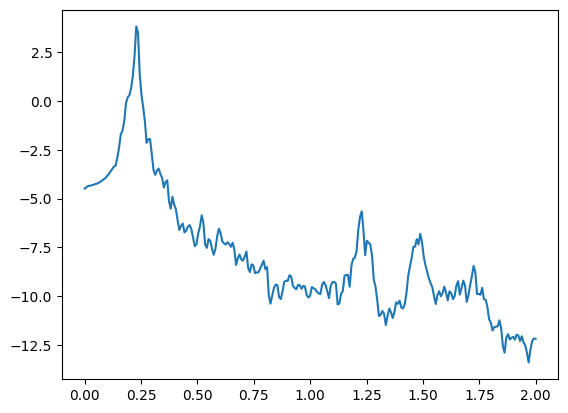

In [ ]:
plt.plot(frequency_axis[0:263], x[0].cpu().numpy())

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from src.model.backcone import SimpleMLP
regressor = SimpleMLP(input_dim=16,hidden_dim=[8,4,2,1])
encoder = model_ae.model.encoder
encoder.eval()
model_all = AutoEncoderRegressor(encoder=encoder, regressor=regressor, lr=5e-3)
mlflow_logger = MLFlowLogger(
    experiment_name="AE-allturbine-Regressor-c01-turbine",
    save_dir=settings.path.mlflow[1:]
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', 
    save_top_k=1, 
    filename='AE-Regressor-{epoch:02d}-{val_loss:.2f}'
)
trainer = pl.Trainer(max_epochs=1000, logger=mlflow_logger, callbacks=[checkpoint_callback])

trainer.fit(model_all, data_loader_dem)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 44.8 K | eval 
1 | regressor | SimpleMLP  | 187    | train
2 | loss_fn   | MSELoss    | 0      | train
3 | model     | Sequential | 45.0 K | train
-------------------------------------------------
187       Trainable params
44.8 K    Non-trainable params
45.0 K    Total params
0.180     Total estimated model params size (MB)
14        Modules in train mode
12        Modules in eval mode


Already set
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x8 and 16x8)

In [ ]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import create_merge_scada
columns = ["Welch","DEM"]
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = [nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 2)),LogTransform()),ToTensor()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM merged 
"""


data_loader_dem = dm.PSDDataModule(
    db_path=db_path,
    view_query=create_merge_scada, 
    view_table_name='merged',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=32,
    cached=True,
)